# Переобучение и недообучение

**Диагностика моделей классификации**

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [19]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
X, y = make_classification(n_samples=10000, n_features=500, 
                           n_informative=50, n_repeated=0, 
                           class_sep=1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=3)

In [20]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression().fit(X_train, y_train)

print(f"Training score: {lr.score(X_train, y_train):.4f}")
print(f"Test score: {lr.score(X_test, y_test):.4f}")

Training score: 0.8415
Test score: 0.8056


То, насколько отличается обучающая и тестовая эффективность модели - основной индикатор пере- или недообучения. Мы явно видим, что тестовая эффективность полученной модели неидеальна. Определить, что является причиной снижения качества модели - ее излишняя или недостаточная вариативность - основная цель диагностики модели машинного обучения.

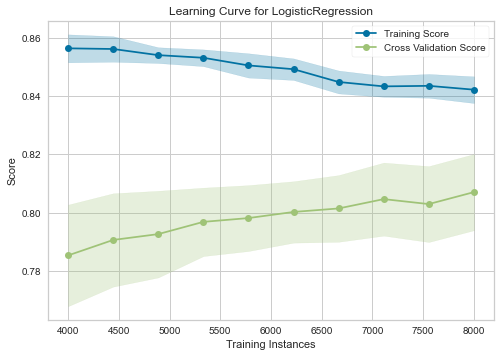

In [7]:
from yellowbrick.model_selection import LearningCurve

visualizer = LearningCurve(
    LogisticRegression(), train_sizes=np.linspace(0.5, 1.0, 10)
).fit(X, y).show() 

 В данном случае, эта функция построит модели логистической регрессии, обученные на 10%, 20%, и так далее до 100% обучающей выборки. А затем по каждой модели будет вычислена обучающая и тестовая эффективности. И эти показатели будут изображены на графике, то есть кривой обучения:

Эта кривая показывает, что когда модель учится на небольшом объеме данных, она имеет прекрасную обучающую эффективность, но плохую тестовую. По мере увеличения объема обучающей выборки, эти эффективности сближаются, но между ними все еще сохраняется зазор.

Напомним, что **большой промежуток между тестовой и обучающей эффективностью свидетельствует о переобучении. А низкое значение обучающей эффективности - о недообучении.** Так что из этого присутствует в данной модели? Можно предположить, что модель немного переобучается.

Мы воспользуемся классификатором на основе гребневой регрессии. Вспомним, что обычный метод наименьших квадратов (воплощением которого является модель логистической регрессии) эквивалентна гребневой модели с параметром регуляризации, равном нулю. Чем больше этот параметр, тем больше регуляризации в модели и тем проще получаемые модели. Если мы предполагаем, что наша исходная модель переобучалась, то давайте построим и оценим модель с большим значением параметра регуляризации:

In [6]:
from sklearn.linear_model import RidgeClassifier
lr = RidgeClassifier(alpha=1000000).fit(X_train, y_train)
# При таком огромном значении регуляризации мы почти гарантированно получим недообученную модель. 
print(f"Training score: {lr.score(X_train, y_train):.4f}")
print(f"Test score: {lr.score(X_test, y_test):.4f}")

Training score: 0.7724
Test score: 0.7712


Обратите внимание, что эффективность стала заметно ниже. Плюс, значения почти совпадают. То есть, почти никакой разницы не осталось. Это подтверждает наш первоначальный вывод о том, что в первой модели разница между обучающей и тестовой эффективностью получилась довольно большой для данной задачи. 

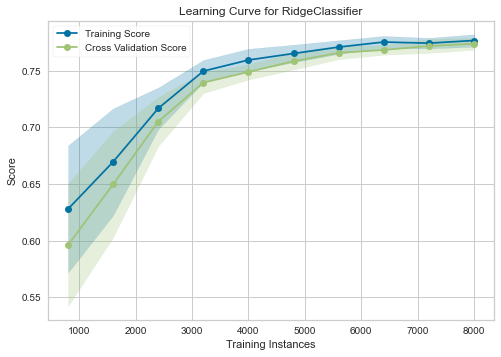

In [7]:
visualizer = LearningCurve(
    RidgeClassifier(alpha=1000000), train_sizes=np.linspace(0.1, 1.0, 10)
).fit(X, y) .show()

Данный график очень характерен для недообучения - низкие значения эффективности и практически никакой разницы между тестовой и обучающей эффективностью.

Если нерегуляризованная модель переобучается, а регуляризованная - недообучается, то где-то в промежутке есть оптимальная модель

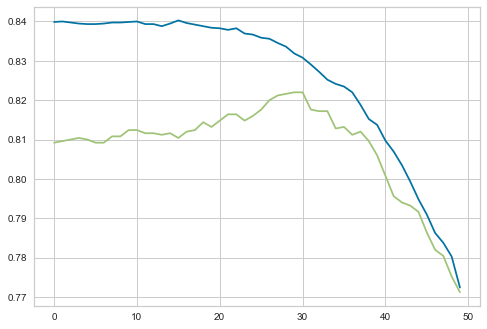

In [8]:
# график зависимости эффективности модели от значения параметра регуляризации
from sklearn.linear_model import RidgeClassifier
trains = []
tests = []
for i in np.logspace(2, 6, 50):
    ridge = RidgeClassifier(alpha=i).fit(X_train, y_train)
    trains.append(ridge.score(X_train, y_train))
    tests.append(ridge.score(X_test, y_test))

plt.plot(trains)
plt.plot(tests);

Здесь мы видим, что при определенных значениях параметра регуляризации тестовая эффективность модели (а нас в конечном итоге интересует именно она) лучше, чем во всех остальных. Подбором или алгоритмически можно найти такое оптимальное значение параметра регуляризации. Оно дает нам модель, которая имеет оптимальный уровень сложности для данного конкретного датасета. Давайте выведем получившиеся показатели:

In [9]:
from sklearn.linear_model import RidgeClassifier
lr = RidgeClassifier(alpha=26500).fit(X_train, y_train)

print(f"Training score: {lr.score(X_train, y_train):.4f}")
print(f"Test score: {lr.score(X_test, y_test):.4f}")

Training score: 0.8311
Test score: 0.8228


Давайте построим кривые обучения, чтобы посмотреть, как они выглядят для "хорошей" модели:

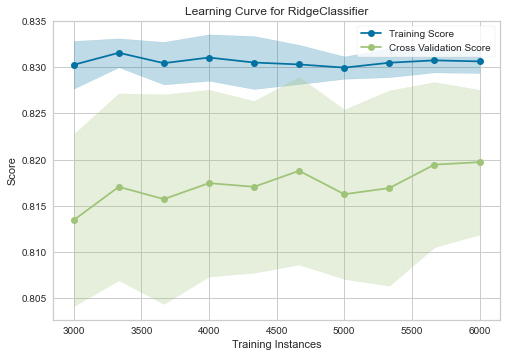

In [10]:
from yellowbrick.model_selection import LearningCurve

visualizer = LearningCurve(
    RidgeClassifier(alpha=26500), train_sizes=np.linspace(0.5, 1.0, 10)
).fit(X_train, y_train).show() 

Опять же, с оглядкой на масштаб вертикальной оси мы видим, что и уровень эффективности выше, чем в первой модели и разница между двумя эффективностями тоже сократилась. И то и другое - это свидетельство большей обобщающей способности модели.

**Диагностика моделей регрессии**

In [11]:
from numpy import genfromtxt
from sklearn.linear_model import LinearRegression
dataset = genfromtxt('https://raw.githubusercontent.com/m-mehdi/tutorials/main/boston_housing.csv', delimiter=',')
X = dataset[:,:-1]
y = dataset[:,-1]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0)

lr = LinearRegression().fit(X_train, y_train)

In [12]:
print(f"Training score: {lr.score(X_train, y_train):.4f}")
print(f"Test score: {lr.score(X_test, y_test):.4f}")

Training score: 0.9521
Test score: 0.6075


Большой разрыв между обучающей и тестовой эффективностью также сразу должен навести на мысль о переобучении данной модели. Попробуем проверить наше предположение при помощи кривых обучения (обратите внимание, что мы сразу используем гребневую модель с очень маленькой регуляризацией):

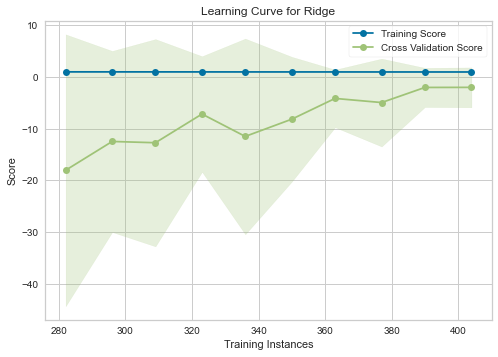

In [13]:
from yellowbrick.model_selection import LearningCurve
from sklearn.linear_model import Ridge
visualizer = LearningCurve(
    Ridge(alpha=0.0001), scoring='r2', train_sizes=np.linspace(0.7, 1.0, 10)
).fit(X, y) .show() 

Обратите внимание, что промежуток между обучающей и тестовой эффективностью все равно очень большой в правой части графика, хоть чисто визуально и не выглядит таковым. Просто тестовая эффективность в левой части графика просто ужасна, и она сильно смещает вертикальную ось вниз. Тем не менее, можно обоснованно предположить, что такая модель переобучается на имеющихся данных.

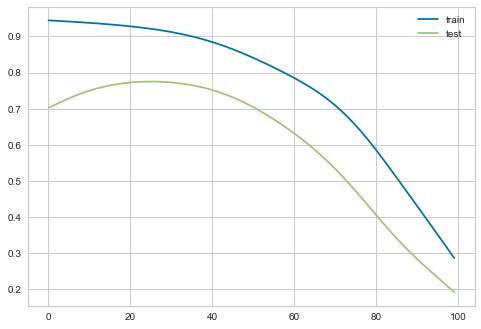

In [14]:
# график зависимости эффективности модели от значения параметра L2-регуляризации:
from sklearn.linear_model import Ridge
trains = []
tests = []
for i in np.logspace(-2, 3, 100):
    ridge = Ridge(alpha=i).fit(X_train, y_train)
    trains.append(ridge.score(X_train, y_train))
    tests.append(ridge.score(X_test, y_test))

plt.plot(trains, label="train")
plt.plot(tests, label="test")
plt.legend();

На этом графике очень наглядно виден характер кривых регуляризации. В левой области лежат значения, которые дают слишком сложные модели. Они хорошо описывают обучающую выборку, но не обобщаются на тестовую. Это зона переобучения. В правой области - значения, порождающие слишком простые модели. Они одинаково плохо описывают и обучающую и тестовые выборки. Это зона недообучения. Посередине между ними лежит оптимальный уровень сложности модели для данного конкретного датасета. Здесь эта оптимальность очень хорошо выражена.

Численно можно подобрать оптимальное значение параметра регуляризации для гребневой регрессии. Давайте выведем эффективность такой оптимальной модели:

In [15]:
lr = Ridge(alpha=0.18).fit(X_train, y_train)

print(f"Linear Regression-Training set score: {lr.score(X_train, y_train):.2f}")
print(f"Linear Regression-Test set score: {lr.score(X_test, y_test):.2f}")

Linear Regression-Training set score: 0.92
Linear Regression-Test set score: 0.77


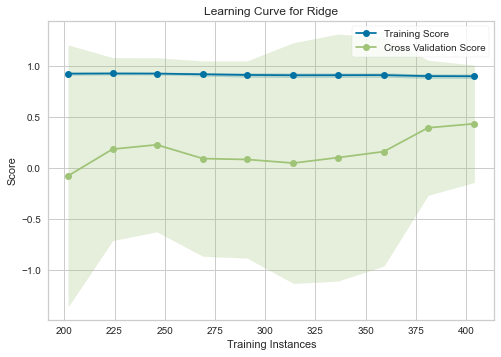

In [16]:
visualizer = LearningCurve(
    Ridge(alpha=0.18), scoring='r2', train_sizes=np.linspace(0.5, 1.0, 10)
).fit(X, y) .show() 

Здесь можно заметить, что несмотря на то, что мы подобрали наилучший уровень сложности модели, ее эффективность все равно не идеальна. Присутствует и разница между тестовой и обучающей эффективностью. Это свидетельствует о том, что и в нашей самой лучшей модели все равно имеется и bias и variance в какой-то степени. И хоть мы нашли лучшую модель, она лучшая из одного отдельного класса моделей - гребневой регрессии.

Поэтому можно исследовать на этом же датасете и другие модели. Так, например, можно попробовать другой вид регуляризации - лассо. В библиотеке sklearn эта модель работает только как регрессор, то есть она не подходит для задач классификации. Поэтому мы не могли использовать ее в предыдущем примере. Сразу построим кривые регуляризации:

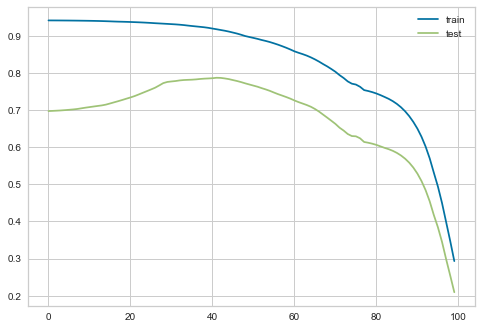

In [17]:
from sklearn.linear_model import Lasso
trains = []
tests = []
for i in np.logspace(-4, 0, 100):
    ridge = Lasso(alpha=i).fit(X_train, y_train)
    trains.append(ridge.score(X_train, y_train))
    tests.append(ridge.score(X_test, y_test))

plt.plot(trains, label="train")
plt.plot(tests, label="test")
plt.legend();

**Диагностика недообучения**

In [18]:
from sklearn.datasets import fetch_openml
data = fetch_openml(name='delta_ailerons') #, parser="auto")
data.data.shape

(7129, 5)

In [19]:
X = pd.get_dummies(data.data)
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
model = LogisticRegression()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)
print("Train score = %.4f" % accuracy_score(y_train, y_train_pred))
print("Test score = %.4f" % accuracy_score(y_test, y_pred))

Train score = 0.6058
Test score = 0.5940


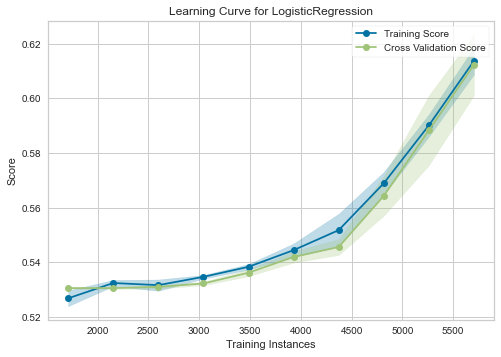

In [21]:
visualizer = LearningCurve(
    LogisticRegression(), scoring='accuracy', train_sizes=np.linspace(0.3, 1.0, 10)
).fit(X, y) .show() 

Здесь очевидны признаки недообучения: низкий уровень обучающей эффективности, малый разрыв между обучающей и тестовой эффективностью. При недообучении регуляризация не поможет, даже навредит, так как еще усилит его. Поэтому единственный путь в этом случае - использовать более сложные, вариативные модели. Можно, например, попробовать многослойный перцептрон:

In [22]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier().fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)
print("Train score = %.4f" % accuracy_score(y_train, y_train_pred))
print("Test score = %.4f" % accuracy_score(y_test, y_pred))

Train score = 0.9386
Test score = 0.9404


In [23]:
# visualizer = LearningCurve(
#     MLPClassifier(), scoring='accuracy', train_sizes=np.linspace(0.3, 1.0, 10)
# ).fit(X_train, y_train) .show() 

In [24]:
# можно ввести полиномиальные признаки
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import PolynomialFeatures
model = RidgeClassifier(alpha=0.001).fit(PolynomialFeatures(2).fit_transform(X_train), y_train)
y_train_pred = model.predict(PolynomialFeatures(2).fit_transform(X_train))
y_pred = model.predict(PolynomialFeatures(2).fit_transform(X_test))
print("Train score = %.4f" % accuracy_score(y_train, y_train_pred))
print("Test score = %.4f" % accuracy_score(y_test, y_pred))

Train score = 0.9392
Test score = 0.9362


Для этой полиномиальной модели уже можно пробовать использовать регуляризацию и строить соответствующие кривые:

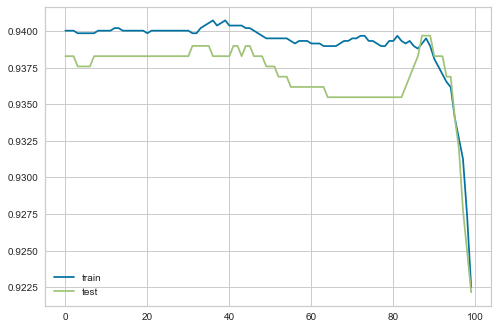

In [25]:
from sklearn.linear_model import RidgeClassifier
trains = []
tests = []
for i in np.logspace(-7, 0, 100):
    ridge = RidgeClassifier(alpha=i).fit(PolynomialFeatures(2).fit_transform(X_train), y_train)
    trains.append(ridge.score(PolynomialFeatures(2).fit_transform(X_train), y_train))
    tests.append(ridge.score(PolynomialFeatures(2).fit_transform(X_test), y_test))

plt.plot(trains, label="train")
plt.plot(tests, label="test")
plt.legend()

В этом примере (как и во многих других реальных случаях) кривая регуляризации уже не такая очевидная и легко читаемая. Но и на ней можно при желании разглядеть область недообучения справа. Область переобучения здесь просматривается не так четко, так как тестовая эффективность практически не падает с уменьшением параметра регуляризации:

# Задания для самостоятельного выполнения

1. Повторите диагностику модели классификации синтетических данных с использованием других метрик эффективности - precision, recall, F1. Как изменились результаты?

In [26]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
X, y = make_classification(n_samples=10000, n_features=500, 
                           n_informative=50, n_repeated=0, 
                           class_sep=1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=3)

In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_train_pred = lr.predict(X_train)
print(f"Training score: {precision_score(y_train, y_train_pred)}")
print(f"Test score: {precision_score(y_test, y_pred)}")
print(f"Training score: {recall_score(y_train, y_train_pred)}")
print(f"Test score: {recall_score(y_test, y_pred)}")
print(f"Training score: {f1_score(y_train, y_train_pred)}")
print(f"Test score: {f1_score(y_test, y_pred)}")

Training score: 0.8339009693476552
Test score: 0.8068635275339185
Training score: 0.8515248796147673
Test score: 0.8055776892430279
Training score: 0.842620780939775
Test score: 0.80622009569378


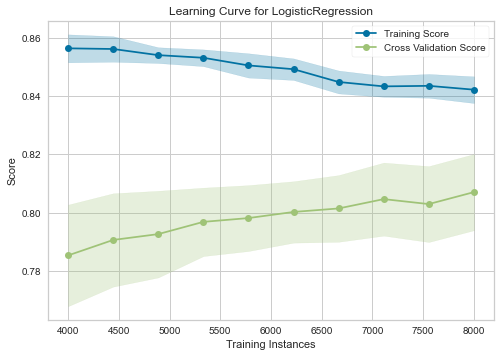

In [29]:
from yellowbrick.model_selection import LearningCurve

visualizer = LearningCurve(
    LogisticRegression(), train_sizes=np.linspace(0.5, 1.0, 10),  scroing='precision_score'
).fit(X, y).show() 

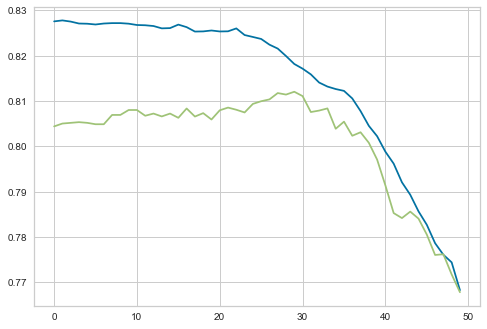

In [42]:
# график зависимости эффективности модели от значения параметра регуляризации
from sklearn.linear_model import RidgeClassifier
trains = []
tests = []
alpha1 = []
for i in np.logspace(2, 6, 50):
    ridge = RidgeClassifier(alpha=i).fit(X_train, y_train)
    y_pred = ridge.predict(X_test)
    y_train_pred = ridge.predict(X_train)
    trains.append(precision_score(y_train, y_train_pred))
    tests.append(precision_score(y_test, y_pred))
    alpha1.append(i)

plt.plot(trains)
plt.plot(tests);

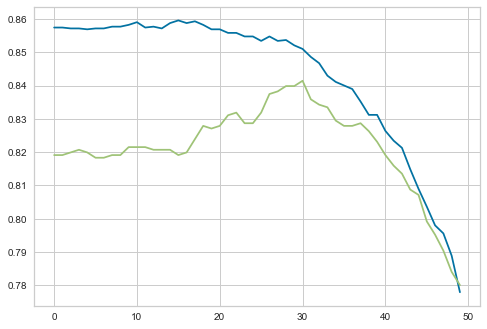

In [44]:
# график зависимости эффективности модели от значения параметра регуляризации
from sklearn.linear_model import RidgeClassifier
trains = []
tests = []
alpha2 = []
for i in np.logspace(2, 6, 50):
    ridge = RidgeClassifier(alpha=i).fit(X_train, y_train)
    y_pred = ridge.predict(X_test)
    y_train_pred = ridge.predict(X_train)
    trains.append(recall_score(y_train, y_train_pred))
    tests.append(recall_score(y_test, y_pred))
    alpha2.append(i)

plt.plot(trains)
plt.plot(tests);

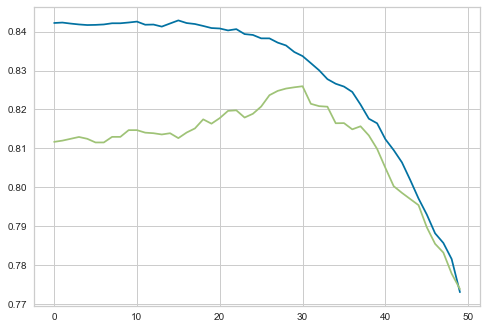

In [45]:
# график зависимости эффективности модели от значения параметра регуляризации
from sklearn.linear_model import RidgeClassifier
trains = []
tests = []
alpha3 = []
for i in np.logspace(2, 6, 50):
    ridge = RidgeClassifier(alpha=i).fit(X_train, y_train)
    y_pred = ridge.predict(X_test)
    y_train_pred = ridge.predict(X_train)
    trains.append(f1_score(y_train, y_train_pred))
    tests.append(f1_score(y_test, y_pred))
    alpha3.append(i)

plt.plot(trains)
plt.plot(tests);

In [41]:
from sklearn.linear_model import RidgeClassifierCV
ridge_cv = RidgeClassifierCV(alpha1, scoring='precision_micro').fit(X_train, y_train)
alpha_opt1 = ridge_cv.alpha_

ridge_cv = RidgeClassifierCV(alpha2, scoring='recall_micro').fit(X_train, y_train)
alpha_opt2 = ridge_cv.alpha_

ridge_cv = RidgeClassifierCV(alpha3, scoring='f1_micro').fit(X_train, y_train)
alpha_opt3 = ridge_cv.alpha_
alpha_opt1, alpha_opt2, alpha_opt3

(100.0, 100.0, 100.0)

In [46]:
from sklearn.linear_model import RidgeClassifier
ridge = RidgeClassifier(alpha=alpha_opt1).fit(X_train, y_train)
y_pred = ridge.predict(X_test)
y_train_pred = ridge.predict(X_train)
print(f"Training score: {precision_score(y_train, y_train_pred)}")
print(f"Test score: {precision_score(y_test, y_pred)}")
print(f"Training score: {recall_score(y_train, y_train_pred)}")
print(f"Test score: {recall_score(y_test, y_pred)}")
print(f"Training score: {f1_score(y_train, y_train_pred)}")
print(f"Test score: {f1_score(y_test, y_pred)}")

Training score: 0.8275238832946037
Test score: 0.8043818466353677
Training score: 0.85741037988229
Test score: 0.8191235059760956
Training score: 0.8422020759427145
Test score: 0.8116857481247532


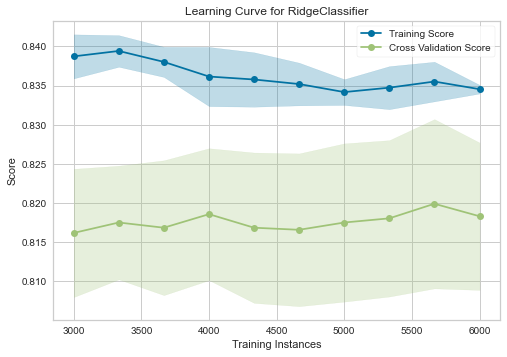

In [36]:
from yellowbrick.model_selection import LearningCurve

visualizer = LearningCurve(
    RidgeClassifier(alpha=alpha_opt), train_sizes=np.linspace(0.5, 1.0, 10)
).fit(X, y).show() 

2. Повторите диагностику модели регрессии с использованием других видов моделей:
    1. метода опорных векторов (исследуйте влияние параметра С на недо-и переобучение)
    2. метода ближайших соседей (исследуйте влияние количества соседей)
    3. метода решающих деревьев (гиперпараметры по вашему выбору)

In [2]:
from numpy import genfromtxt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
dataset = genfromtxt('https://raw.githubusercontent.com/m-mehdi/tutorials/main/boston_housing.csv', delimiter=',')
X = dataset[:,:-1]
y = dataset[:,-1]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0)

reg = SVR().fit(X_train, y_train)

In [52]:
print(f"Training score: {reg.score(X_train, y_train):.4f}")
print(f"Test score: {reg.score(X_test, y_test):.4f}")

Training score: 0.6505
Test score: 0.4488


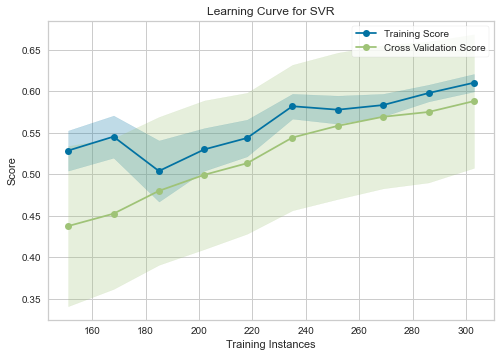

In [3]:
########
from yellowbrick.model_selection import LearningCurve
visualizer = LearningCurve(
    SVR(), train_sizes=np.linspace(0.5, 1.0, 10)
).fit(X, y).show() 

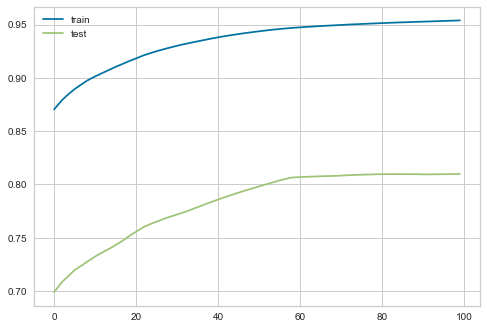

In [59]:
# график зависимости эффективности модели от значения параметра C-регуляризации:
trains = []
tests = []
for i in np.linspace(10, 100, 100):
    reg = SVR(C=i).fit(X_train, y_train)
    trains.append(reg.score(X_train, y_train))
    tests.append(reg.score(X_test, y_test))

plt.plot(trains, label="train")
plt.plot(tests, label="test")
plt.legend();

In [61]:
from sklearn.neighbors import KNeighborsRegressor
reg = KNeighborsRegressor().fit(X_train, y_train)
print(f"Training score: {reg.score(X_train, y_train):.4f}")
print(f"Test score: {reg.score(X_test, y_test):.4f}")

Training score: 0.8328
Test score: 0.5586


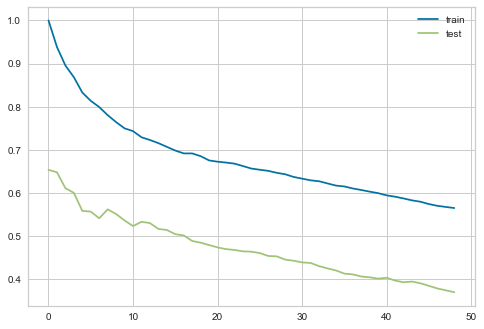

In [64]:
# график зависимости эффективности модели от значения параметра k-регуляризации:
trains = []
tests = []
for i in range(1, 50):
    reg = KNeighborsRegressor(n_neighbors=i).fit(X_train, y_train)
    trains.append(reg.score(X_train, y_train))
    tests.append(reg.score(X_test, y_test))

plt.plot(trains, label="train")
plt.plot(tests, label="test")
plt.legend();

In [65]:
from sklearn.tree import DecisionTreeRegressor
reg = DecisionTreeRegressor().fit(X_train, y_train)
print(f"Training score: {reg.score(X_train, y_train):.4f}")
print(f"Test score: {reg.score(X_test, y_test):.4f}")

Training score: 1.0000
Test score: 0.6044


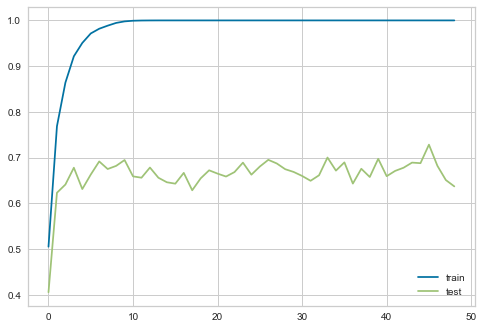

In [66]:
# график зависимости эффективности модели от значения параметра k-регуляризации:
trains = []
tests = []
for i in range(1, 50):
    reg = DecisionTreeRegressor(max_depth=i).fit(X_train, y_train).fit(X_train, y_train)
    trains.append(reg.score(X_train, y_train))
    tests.append(reg.score(X_test, y_test))

plt.plot(trains, label="train")
plt.plot(tests, label="test")
plt.legend();

3. Дополните анализ датасета Бостон исследованием модели лассо - постройте кривые обучения для переобученной, недообученной и качественной модели, найдите оптимальное значение параметра регуляризации в модели лассо.

In [68]:
ridge = Lasso().fit(X_train, y_train)
print(f"Training score: {ridge.score(X_train, y_train):.4f}")
print(f"Test score: {ridge.score(X_test, y_test):.4f}")

Training score: 0.2932
Test score: 0.2094


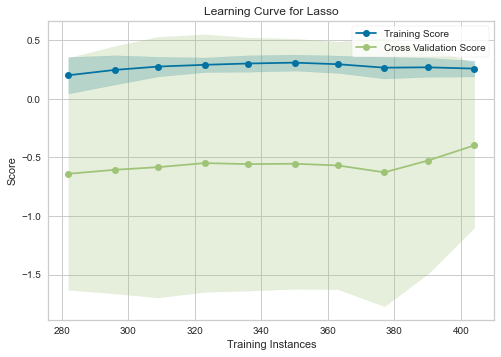

In [78]:
# недообученная
visualizer = LearningCurve(
    Lasso(), train_sizes=np.linspace(0.7, 1.0, 10)
).fit(X, y) .show() 

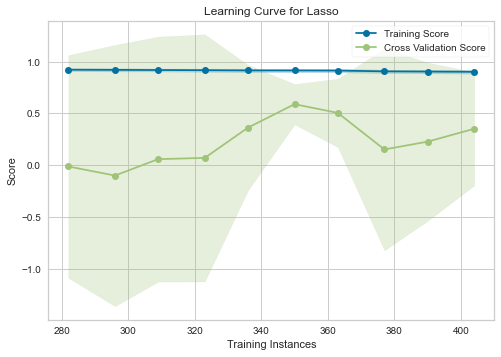

In [94]:
# переобученная
visualizer = LearningCurve(
    Lasso(alpha=0.0043), train_sizes=np.linspace(0.7, 1.0, 10)
).fit(X, y) .show() 

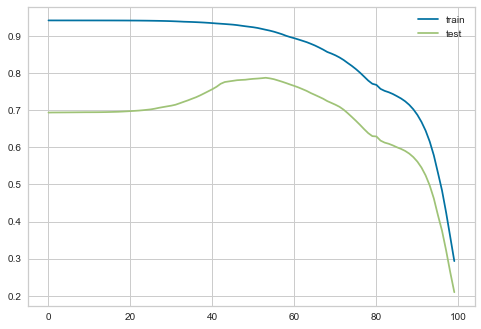

In [90]:
from sklearn.linear_model import Lasso
trains = []
tests = []
alpha = []
for i in np.logspace(-5, 0, 100):
    ridge = Lasso(alpha=i).fit(X_train, y_train)
    trains.append(ridge.score(X_train, y_train))
    tests.append(ridge.score(X_test, y_test))
    alpha.append(i)

plt.plot(trains, label="train")
plt.plot(tests, label="test")
plt.legend();

In [91]:
from sklearn.linear_model import LassoCV
lasso_cv = LassoCV(alphas=alpha).fit(X_train, y_train)
alpha_opt = lasso_cv.alpha_

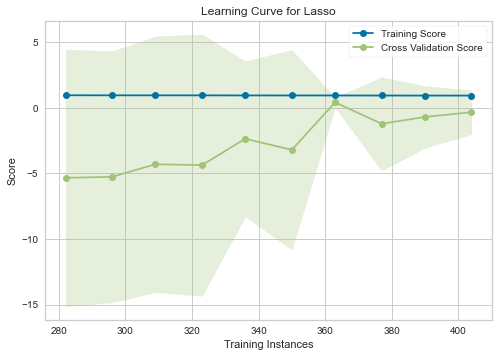

In [93]:
# оптимальная
visualizer = LearningCurve(
    Lasso(alpha=alpha_opt), train_sizes=np.linspace(0.7, 1.0, 10)
).fit(X, y) .show() 

4. В одном из двух первых примеров используйте модель ElasticNet и исследуйте влияние сразу двух параметров регуляризации на эффективность модели.

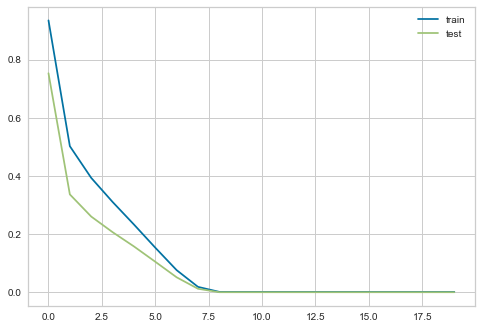

In [15]:
trains = []
tests = []
for i in np.linspace(0.00001, 1, 20):
    reg = ElasticNet(alpha=i*10, l1_ratio=i).fit(X_train, y_train)
    trains.append(reg.score(X_train, y_train))
    tests.append(reg.score(X_test, y_test))

plt.plot(trains, label="train")
plt.plot(tests, label="test")
plt.legend();

5. Дополните анализ дерева решений из третьего примера: постройте кривые регуляризации для полного датасета, найдите оптимальную глубину дерева и оцените качество такой модели на всем датасете. Повторите данный анализ используя в качестве метрики эффективности F1.

In [23]:
from sklearn.tree import DecisionTreeClassifier
df = pd.read_csv('https://raw.githubusercontent.com/koroteevmv/ML_course/2023_new/ML4.3%20diagnostics/diabetes.csv')
target = "Outcome"
y = df[target]
X = df.drop(target, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeClassifier(random_state=1).fit(X_train, y_train)
print(f"Training score: {model.score(X_train, y_train):.4f}")
print(f"Test score: {model.score(X_test, y_test):.4f}")

Training score: 1.0000
Test score: 0.7273


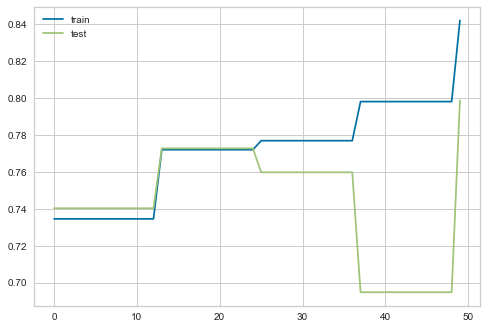

In [24]:
trains = []
tests = []
max_depths = []
for i in np.linspace(1, 5, 50):
    clf = DecisionTreeClassifier(max_depth=i, random_state=1).fit(X_train, y_train)
    trains.append(clf.score(X_train, y_train))
    tests.append(clf.score(X_test, y_test))
    max_depths.append(i)
plt.plot(trains, label="train")
plt.plot(tests, label="test")
plt.legend();

In [25]:
max_depth_opt = max_depths[21]

In [26]:
model = DecisionTreeClassifier(max_depth=max_depth_opt, random_state=1).fit(X_train, y_train)
print(f"Training score: {model.score(X_train, y_train):.4f}")
print(f"Test score: {model.score(X_test, y_test):.4f}")

Training score: 0.7720
Test score: 0.7727


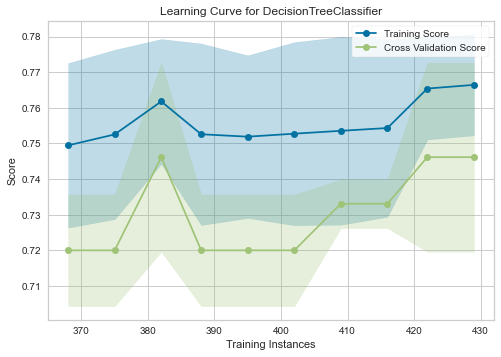

In [27]:
# оптимальная
visualizer = LearningCurve(
    DecisionTreeClassifier(max_depth=max_depth_opt), train_sizes=np.linspace(0.6, 0.7, 10)
).fit(X, y) .show() 

In [28]:
from sklearn.datasets import fetch_openml
data = fetch_openml(name='delta_ailerons')
data.data.shape

(7129, 5)

In [10]:
X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5)

In [29]:
y

0      1
1      0
2      1
3      0
4      1
      ..
763    0
764    0
765    0
766    1
767    0
Name: Outcome, Length: 768, dtype: int64

In [11]:
print(data.DESCR)

**Author**:   
**Source**: Unknown - Date unknown  
**Please cite**:   

Binarized version of the original data set (see version 1). It converts the numeric target feature to a two-class nominal target feature by computing the mean and classifying all instances with a lower target value as positive ('P') and all others as negative ('N').

Downloaded from openml.org.


In [13]:
from sklearn import metrics
reg = LogisticRegression().fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
y_pred = reg.predict(X_test)

print(metrics.classification_report(y_test, y_pred))
print(metrics.classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           N       0.99      0.22      0.36       823
           P       0.60      1.00      0.75       960

    accuracy                           0.64      1783
   macro avg       0.79      0.61      0.55      1783
weighted avg       0.78      0.64      0.57      1783

              precision    recall  f1-score   support

           N       0.99      0.20      0.34      2523
           P       0.58      1.00      0.74      2823

    accuracy                           0.62      5346
   macro avg       0.79      0.60      0.54      5346
weighted avg       0.78      0.62      0.55      5346



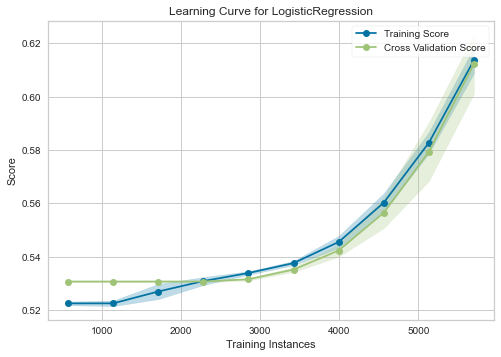

In [14]:
LearningCurve(
    reg, scoring='f1_micro', train_sizes=np.linspace(0.1, 1.0, 10)
).fit(X, y).show();

In [16]:
from sklearn.svm import SVC
clf = SVC().fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred), metrics.classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           N       0.94      0.92      0.93       823
           P       0.93      0.95      0.94       960

    accuracy                           0.94      1783
   macro avg       0.94      0.93      0.94      1783
weighted avg       0.94      0.94      0.94      1783
               precision    recall  f1-score   support

           N       0.96      0.92      0.94      2523
           P       0.93      0.96      0.95      2823

    accuracy                           0.94      5346
   macro avg       0.94      0.94      0.94      5346
weighted avg       0.94      0.94      0.94      5346



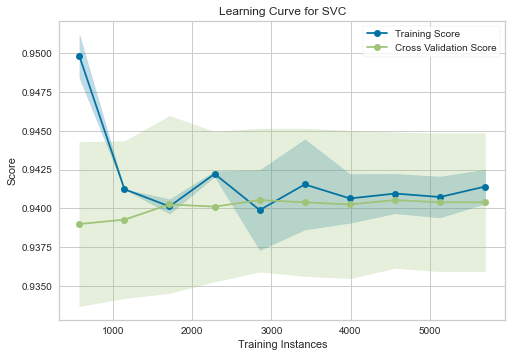

In [17]:
LearningCurve(
    SVC(), scoring='f1_micro', train_sizes=np.linspace(0.1, 1.0, 10)
).fit(X, y).show();